# Detecção de fraudes

A detecção de fraudes bancárias é um desafio crescente no setor financeiro, e as redes neurais desempenham um papel crucial na identificação de atividades fraudulentas. Elas são capazes de processar grandes volumes de dados, detectar padrões complexos e não lineares, e aprender continuamente com novos comportamentos de fraude. Com essa capacidade de adaptação e análise em tempo real, as redes neurais conseguem identificar anomalias e comportamentos suspeitos, tornando-se uma ferramenta eficaz na prevenção de fraudes.

Neste contexto o objetivo principal do nosso projeto é desenvolver um algoritmo utilizando o PyTorch que seja capaz de detectar transações fraudulentas.

__Fonte dos dados__: https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud

## Conhecendo os dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
from torch.utils.data import Dataset

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\mathe\Downloads\archive (18)\card_transdata.csv")

In [3]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


Explicação das colunas:

distance_from_home - a distância da casa onde a transação ocorreu.

distance_from_last_transaction - a distância desde a última transação.

ratio_to_median_purchase_price - Proporção entre o preço de transação adquirido e o preço médio de compra.

repeat_retailer - A transação ocorreu no mesmo varejista.

used_chip - A transação é feita por chip (cartão de crédito).

used_pin_number - Se a transação ocorreu usando um número PIN.

online_order - Se a transação é um pedido on-line.

fraud -Se a transação é fraudulenta.

## Análise exploratória

Neste ponto vou optar por pegar um sample da base de dados (por motivos de limitação de hardware).

In [4]:
df = df.sample(n = 20000, random_state = 42)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 987231 to 809896
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   distance_from_home              20000 non-null  float64
 1   distance_from_last_transaction  20000 non-null  float64
 2   ratio_to_median_purchase_price  20000 non-null  float64
 3   repeat_retailer                 20000 non-null  float64
 4   used_chip                       20000 non-null  float64
 5   used_pin_number                 20000 non-null  float64
 6   online_order                    20000 non-null  float64
 7   fraud                           20000 non-null  float64
dtypes: float64(8)
memory usage: 1.4 MB


In [6]:
df.dropna(inplace = True)

In [7]:
df.duplicated().sum()

0

In [8]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000
mean,26.044328,5.358050,1.807895,0.87970,0.352850,0.099700,0.652800,0.085350
std,57.283798,22.149115,2.764176,0.32532,0.477868,0.299607,0.476092,0.279409
min,0.024144,0.000539,0.010936,0.00000,0.000000,0.000000,0.000000,0.000000
25%,3.814096,0.302109,0.475894,1.00000,0.000000,0.000000,0.000000,0.000000
50%,9.857502,1.015524,0.993782,1.00000,0.000000,0.000000,1.000000,0.000000
75%,25.839295,3.433691,2.085567,1.00000,1.000000,0.000000,1.000000,0.000000
max,2146.055760,885.429012,67.929616,1.00000,1.000000,1.000000,1.000000,1.000000


### Variáveis categóricas

In [9]:
## Configurações de formatação do gráfico
sns.set_palette('Accent')
sns.set_style('white')

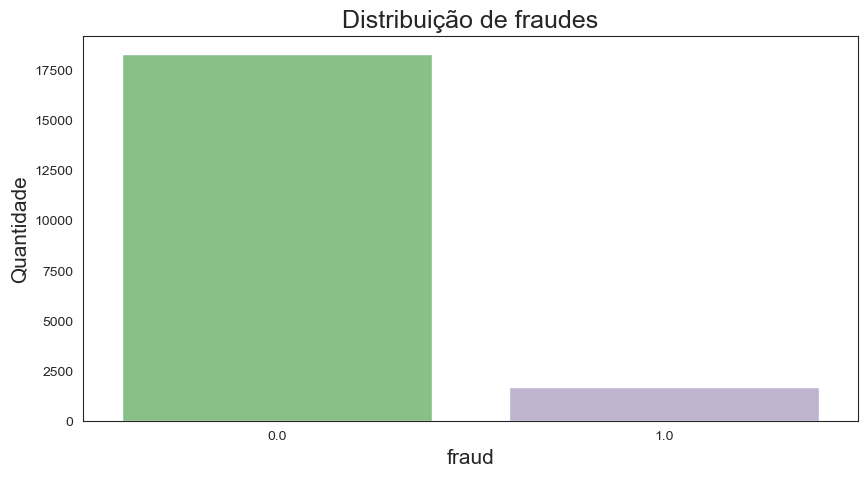

In [10]:
ax, fig = plt.subplots(figsize=(10, 5))

ax = sns.countplot(x='fraud', data=df)
plt.title('Distribuição de fraudes', size = 18)
plt.xlabel('fraud', size = 15)
plt.ylabel('Quantidade', size = 15)
plt.show()

Inicialmente já vemos uma grande diferença na distribuição de dados, isso indica a necessidade de posteiror balanceamento.

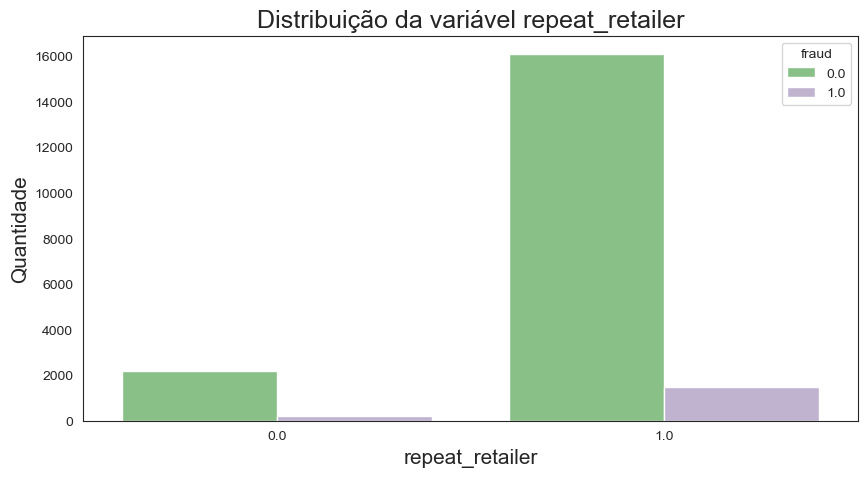

In [11]:
ax, fig = plt.subplots(figsize=(10, 5))

ax = sns.countplot(x = 'repeat_retailer', data = df, hue = 'fraud')
plt.title('Distribuição da variável repeat_retailer', size = 18)
plt.xlabel('repeat_retailer', size = 15)
plt.ylabel('Quantidade', size = 15)
plt.show()

Vemos um número maior de transações fraudulentas em compras feitas em um mesmo varejista.

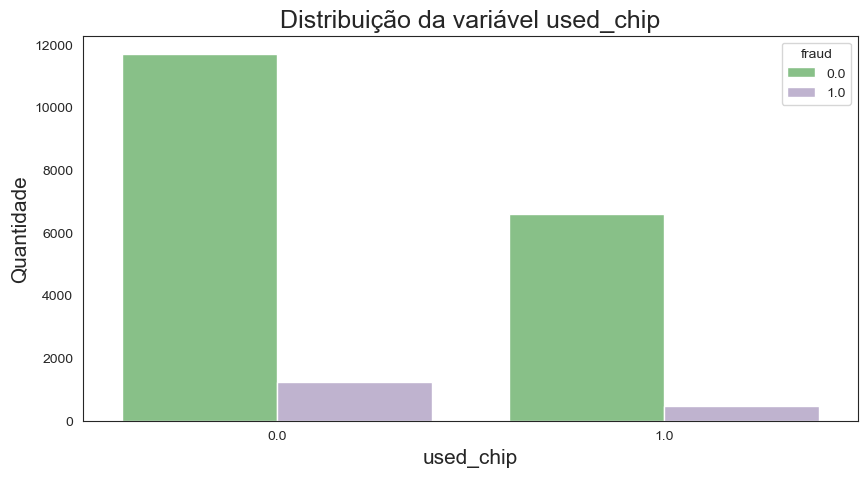

In [12]:
ax, fig = plt.subplots(figsize=(10, 5))

ax = sns.countplot(x = 'used_chip', data = df, hue = 'fraud')
plt.title('Distribuição da variável used_chip', size = 18)
plt.xlabel('used_chip', size = 15)
plt.ylabel('Quantidade', size = 15)
plt.show()

A maior parte das transações não são feitas por cartão de crédito. Vemos uma maior quantidade de transações fraudulentas nas operações sem cartão de crédito.

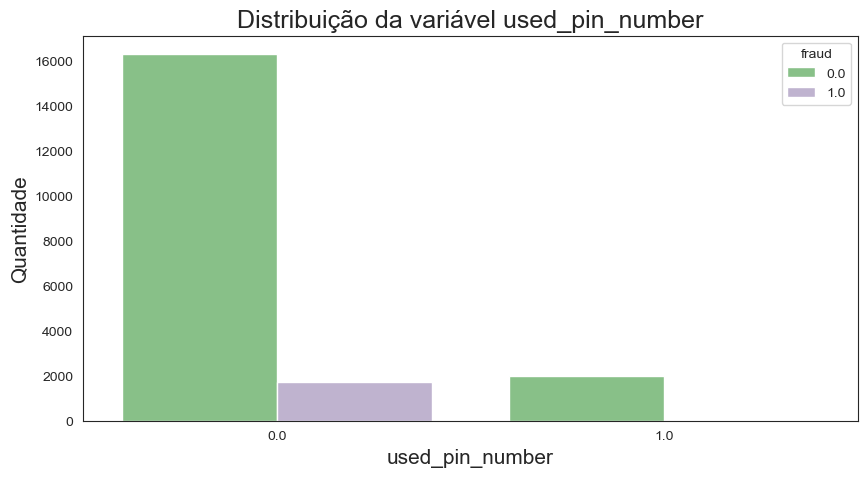

In [13]:
ax, fig = plt.subplots(figsize=(10, 5))

ax = sns.countplot(x = 'used_pin_number', data = df, hue = 'fraud')
plt.title('Distribuição da variável used_pin_number', size = 18)
plt.xlabel('used_pin_number', size = 15)
plt.ylabel('Quantidade', size = 15)
plt.show()

A maior parte das transações não usam um número PIN. Além disso, não temos transações fraudulentas quando o número PIN é utilizado.

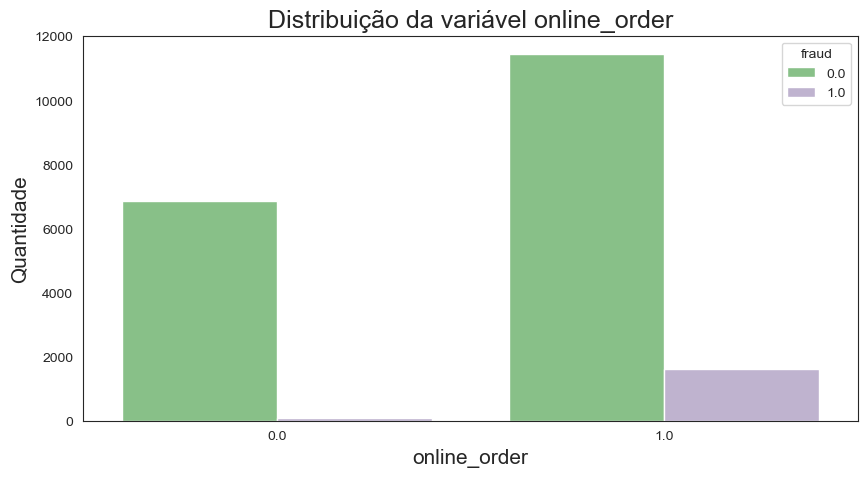

In [14]:
ax, fig = plt.subplots(figsize=(10, 5))

ax = sns.countplot(x = 'online_order', data = df, hue = 'fraud')
plt.title('Distribuição da variável online_order', size = 18)
plt.xlabel('online_order', size = 15)
plt.ylabel('Quantidade', size = 15)
plt.show()

A maior parte das transações são feitas online. Vemos também que as transações fraudulentas ocorrem majoritariamente online.

### Variáveis númericas

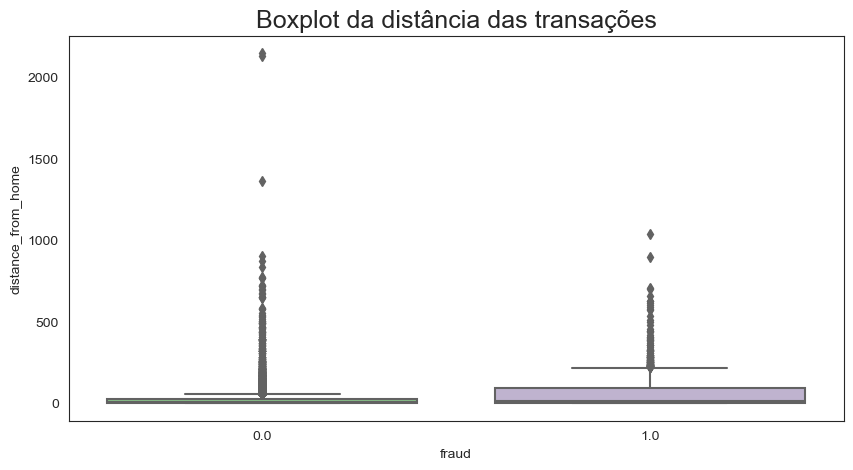

In [15]:
ax, fig = plt.subplots(figsize=(10, 5))

ax = sns.boxplot(x='fraud', y='distance_from_home', data=df)
plt.title('Boxplot da distância das transações', size = 18)
plt.show()

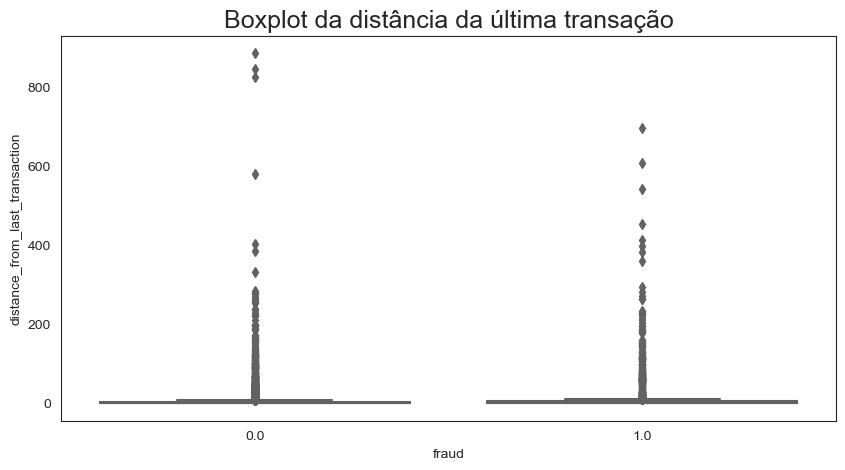

In [16]:
ax, fig = plt.subplots(figsize=(10, 5))

ax = sns.boxplot(x='fraud', y='distance_from_last_transaction', data=df)
plt.title('Boxplot da distância da última transação', size = 18)
plt.show()

Ambos os gráficos apresentam possíves outliers, entretanto, como são valores reais e se tratam de distâncias não iremos tratá-los. Outro ponto que podemos concluir é que vamos precisar normalizar nossos dados dado a diferença entre os valores.

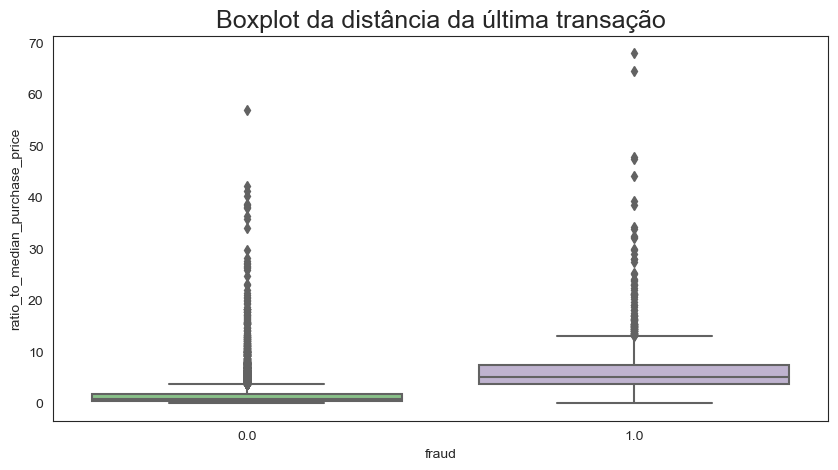

In [17]:
ax, fig = plt.subplots(figsize=(10, 5))

ax = sns.boxplot(x='fraud', y='ratio_to_median_purchase_price', data=df)
plt.title('Boxplot da distância da última transação', size = 18)
plt.show()

Temos possíves outliers e seguiremos o mesmo tratamento do caso anterior.

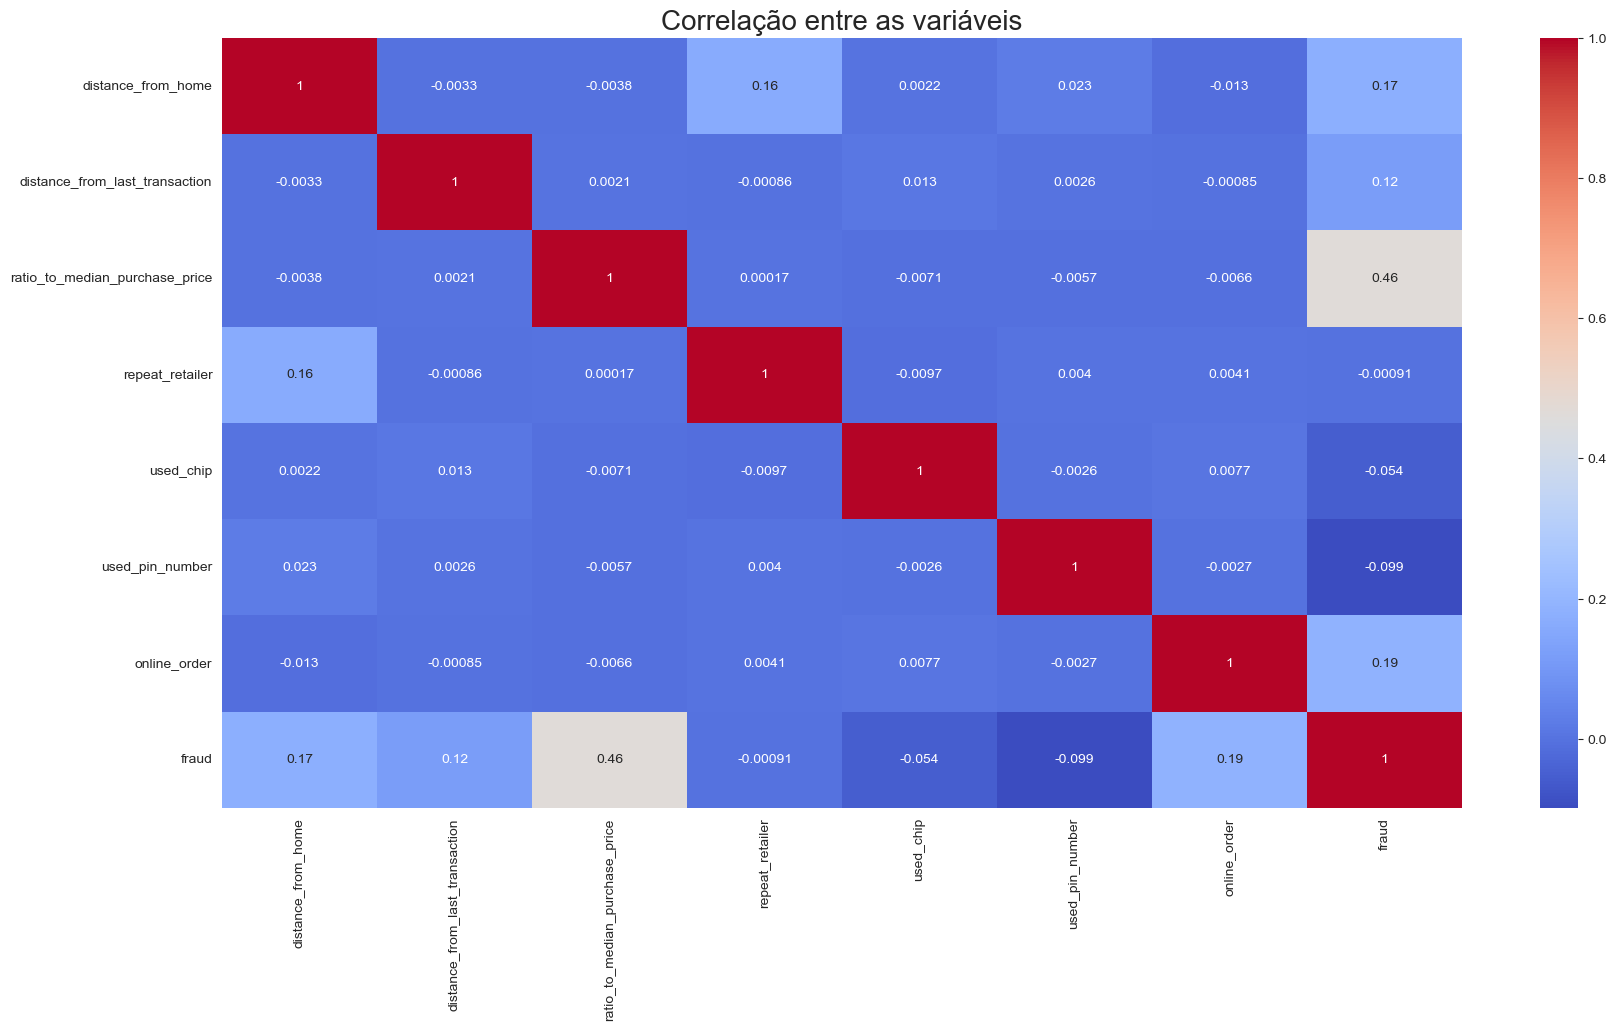

In [18]:
plt.figure(figsize = (20,10))
sns.heatmap(df.corr(), annot=True , cmap ='coolwarm' )
plt.title("Correlação entre as variáveis", size = 20)
plt.show()

## Pré-processamento

In [19]:
## Separando os dados

X = df.drop('fraud', axis=1)
y = df.fraud

In [20]:
## Fazendo o split em treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [21]:
## Normalizando os dados

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
## Balanceando os dados

smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

## Treinando o modelo

In [23]:
# Configurando hiperparâmetros.
args = {
    'epoch_num': 350,     # Número de épocas.
    'lr': 1e-5,           # Taxa de aprendizado.
    'weight_decay': 5e-4, # Penalidade L2 (Regularização).
    'num_workers': 0,     # Número de threads do dataloader.
    'batch_size': 512,     # Tamanho do batch.
}

# Definição do hardware utilizado
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cpu


In [24]:
# Classe dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Criando o dataset
train_dataset = CustomDataset(X_train_balanced, y_train_balanced)
test_dataset = CustomDataset(X_test_scaled, y_test)

In [25]:
# Criando dataloader
train_loader = DataLoader(train_dataset,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle = True)
test_loader = DataLoader(test_dataset,
                         args['batch_size'],
                         num_workers = args['num_workers'],
                         shuffle = True)

In [26]:
# Criando o MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(MLP, self).__init__()

        self.features = nn.Sequential(
                nn.Linear(input_size, hidden_size_2), # input layer 
                nn.ReLU(),
                nn.Linear(hidden_size_2,  hidden_size_1), # hidden layer 
                nn.ReLU(),
                nn.Linear(hidden_size_1,  hidden_size_1), # hidden layer 
                nn.ReLU(),
                nn.Linear(hidden_size_1,  hidden_size_1), # hidden layer
                nn.ReLU(),
                nn.Linear(hidden_size_1, hidden_size_1),  # hidden layer
                nn.ReLU(),
                nn.Linear(hidden_size_1, hidden_size_1), # hidden layer 
                nn.ReLU()
                  )
        self.out = nn.Linear(hidden_size_1, output_size)  #output layer
        self.softmax = nn.Softmax()
    def forward(self, X):
        feature = self.features(X)
        output  = self.softmax(self.out(feature))

        return output


input_size = len(X_train_balanced[0])
hidden_size_1 = 128
hidden_size_2 = 64
output_size = 2

model = MLP(input_size, hidden_size_1, hidden_size_2, output_size)
model.to(args['device'])

MLP(
  (features): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): ReLU()
  )
  (out): Linear(in_features=128, out_features=2, bias=True)
  (softmax): Softmax(dim=None)
)

In [27]:
## Definindo a loss function e o otimizador
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(model.parameters(), lr = args['lr'], weight_decay = args['weight_decay'])

In [28]:
# Função para treino

def train(train_loader, net, epoch):
    net.train()
    epoch_loss, pred_list, rotulo_list = [], [], []
    for batch in train_loader:
        dado, rotulo = batch
        # Cast dos dados
        dado = dado.to(args['device'])
        rotulo = rotulo.to(args['device'])
        # Forward
        pred = net(dado)
        loss = criterion(pred, rotulo)
        epoch_loss.append(loss.item())

        # Backward pass e otimização
        optimizer.zero_grad()  # Zera os gradientes
        loss.backward()        # Calcula os gradientes
        optimizer.step()       # Atualiza os pesos

        # Definições para cálculo da acurácia
        _, pred = torch.max(pred, axis=1)
        pred_list.extend(pred.cpu().numpy())
        rotulo_list.extend(rotulo.cpu().numpy())


    epoch_loss = np.asarray(epoch_loss)
    pred_list  = np.asarray(pred_list)
    rotulo_list  = np.asarray(rotulo_list)
    # Calcula a acurácia
    acc = accuracy_score(rotulo_list, pred_list)

    print(f'Epoch: {epoch}, Loss: {epoch_loss.mean()}, Acc: {acc}')

    return epoch_loss.mean(), acc

In [29]:
# Função para validação

def test(train_loader, net, epoch):
    net.eval()
    epoch_loss, pred_list, rotulo_list = [], [], []
    true_labels, pred_labels = [], []
    for batch in train_loader:
        dado, rotulo = batch
        # Cast dos dados
        dado = dado.to(args['device'])
        rotulo = rotulo.to(args['device'])
        # Forward
        pred = net(dado)
        loss = criterion(pred, rotulo)
        epoch_loss.append(loss.item())
        # Definições para cálculo da acurácia
        _, pred = torch.max(pred, axis=1)
        pred_list.extend(pred.cpu().numpy())
        rotulo_list.extend(rotulo.cpu().numpy())
        # Coleta os rótulos reais e as previsões
        true_labels.extend(rotulo.cpu().numpy()) 
        pred_labels.extend(pred.cpu().numpy())
        
    epoch_loss = np.asarray(epoch_loss)
    pred_list  = np.asarray(pred_list)
    rotulo_list  = np.asarray(rotulo_list)
    
    acc = accuracy_score(rotulo_list, pred_list)


    print(f'Epoch: {epoch}, Loss: {epoch_loss.mean()}, Acc: {acc}')

    return epoch_loss.mean(), acc, true_labels, pred_labels

In [30]:
train_losses, test_losses, train_acc, test_acc = [], [], [], []

for epoch in range(args['epoch_num']):
    # Train
    print(' -------------- Train ------------------')
    train_loss, train_accuracy = train(train_loader, model, epoch)
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)

    print(' -------------- Validate ------------------')
    # Validate
    test_loss, test_accuracy, _, _ = test(test_loader, model, epoch)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)

 -------------- Train ------------------
Epoch: 0, Loss: 0.6934761672184385, Acc: 0.5
 -------------- Validate ------------------
Epoch: 0, Loss: 0.7191552594304085, Acc: 0.08525
 -------------- Train ------------------
Epoch: 1, Loss: 0.6928395690589115, Acc: 0.5
 -------------- Validate ------------------
Epoch: 1, Loss: 0.718183234333992, Acc: 0.08525
 -------------- Train ------------------
Epoch: 2, Loss: 0.6920194769727772, Acc: 0.5
 -------------- Validate ------------------
Epoch: 2, Loss: 0.7175396680831909, Acc: 0.08525
 -------------- Train ------------------
Epoch: 3, Loss: 0.6906875721339522, Acc: 0.5
 -------------- Validate ------------------
Epoch: 3, Loss: 0.716801606118679, Acc: 0.08525
 -------------- Train ------------------
Epoch: 4, Loss: 0.6886297741840626, Acc: 0.5
 -------------- Validate ------------------
Epoch: 4, Loss: 0.716578982770443, Acc: 0.08525
 -------------- Train ------------------
Epoch: 5, Loss: 0.6850840737079752, Acc: 0.5
 -------------- Valida

Epoch: 43, Loss: 0.34182133191618425, Acc: 0.9757755910892443
 -------------- Validate ------------------
Epoch: 43, Loss: 0.3546024076640606, Acc: 0.9595
 -------------- Train ------------------
Epoch: 44, Loss: 0.34107658215637865, Acc: 0.9760489271559383
 -------------- Validate ------------------
Epoch: 44, Loss: 0.3540707640349865, Acc: 0.9605
 -------------- Train ------------------
Epoch: 45, Loss: 0.3404140708775356, Acc: 0.9767322673226733
 -------------- Validate ------------------
Epoch: 45, Loss: 0.3547939546406269, Acc: 0.95825
 -------------- Train ------------------
Epoch: 46, Loss: 0.3400900790403629, Acc: 0.9765955992893263
 -------------- Validate ------------------
Epoch: 46, Loss: 0.3537987768650055, Acc: 0.96
 -------------- Train ------------------
Epoch: 47, Loss: 0.33938498127049416, Acc: 0.9768689353560203
 -------------- Validate ------------------
Epoch: 47, Loss: 0.35251956433057785, Acc: 0.96075
 -------------- Train ------------------
Epoch: 48, Loss: 0.33

Epoch: 85, Loss: 0.3325550890174405, Acc: 0.9820281536148695
 -------------- Validate ------------------
Epoch: 85, Loss: 0.34138865768909454, Acc: 0.971
 -------------- Train ------------------
Epoch: 86, Loss: 0.33201213592085344, Acc: 0.9822673226732267
 -------------- Validate ------------------
Epoch: 86, Loss: 0.3413470461964607, Acc: 0.971
 -------------- Train ------------------
Epoch: 87, Loss: 0.3321737950218135, Acc: 0.9823356566899002
 -------------- Validate ------------------
Epoch: 87, Loss: 0.34142955020070076, Acc: 0.9705
 -------------- Train ------------------
Epoch: 88, Loss: 0.3324946627534669, Acc: 0.9824381577149105
 -------------- Validate ------------------
Epoch: 88, Loss: 0.3408866114914417, Acc: 0.97075
 -------------- Train ------------------
Epoch: 89, Loss: 0.3318961493927857, Acc: 0.982506491731584
 -------------- Validate ------------------
Epoch: 89, Loss: 0.3406149186193943, Acc: 0.972
 -------------- Train ------------------
Epoch: 90, Loss: 0.331651

Epoch: 127, Loss: 0.3283690229572099, Acc: 0.9858890255569223
 -------------- Validate ------------------
Epoch: 127, Loss: 0.33410149812698364, Acc: 0.97925
 -------------- Train ------------------
Epoch: 128, Loss: 0.3285066654969906, Acc: 0.9859915265819325
 -------------- Validate ------------------
Epoch: 128, Loss: 0.33476483821868896, Acc: 0.97925
 -------------- Train ------------------
Epoch: 129, Loss: 0.32835504104351176, Acc: 0.9862306956402898
 -------------- Validate ------------------
Epoch: 129, Loss: 0.3347669579088688, Acc: 0.97875
 -------------- Train ------------------
Epoch: 130, Loss: 0.3284090320611822, Acc: 0.986196528631953
 -------------- Validate ------------------
Epoch: 130, Loss: 0.33468445390462875, Acc: 0.97925
 -------------- Train ------------------
Epoch: 131, Loss: 0.328710088955945, Acc: 0.9863331966653
 -------------- Validate ------------------
Epoch: 131, Loss: 0.33415813744068146, Acc: 0.97925
 -------------- Train ------------------
Epoch: 132

Epoch: 169, Loss: 0.3260159749409248, Acc: 0.988246549132158
 -------------- Validate ------------------
Epoch: 169, Loss: 0.33105145394802094, Acc: 0.9825
 -------------- Train ------------------
Epoch: 170, Loss: 0.3256114839479841, Acc: 0.9884173841738417
 -------------- Validate ------------------
Epoch: 170, Loss: 0.3300844579935074, Acc: 0.9835
 -------------- Train ------------------
Epoch: 171, Loss: 0.32630789434087687, Acc: 0.9884515511821785
 -------------- Validate ------------------
Epoch: 171, Loss: 0.33087143674492836, Acc: 0.9825
 -------------- Train ------------------
Epoch: 172, Loss: 0.32554979005764273, Acc: 0.9884857181905152
 -------------- Validate ------------------
Epoch: 172, Loss: 0.3299475759267807, Acc: 0.983
 -------------- Train ------------------
Epoch: 173, Loss: 0.3256751771630912, Acc: 0.9887248872488725
 -------------- Validate ------------------
Epoch: 173, Loss: 0.3297039605677128, Acc: 0.983
 -------------- Train ------------------
Epoch: 174, Lo

Epoch: 211, Loss: 0.32315070207776697, Acc: 0.9908774087740877
 -------------- Validate ------------------
Epoch: 211, Loss: 0.3261342868208885, Acc: 0.98675
 -------------- Train ------------------
Epoch: 212, Loss: 0.3231818151885065, Acc: 0.9908774087740877
 -------------- Validate ------------------
Epoch: 212, Loss: 0.3260044865310192, Acc: 0.987
 -------------- Train ------------------
Epoch: 213, Loss: 0.32325631123164605, Acc: 0.9910482438157715
 -------------- Validate ------------------
Epoch: 213, Loss: 0.32664672285318375, Acc: 0.98625
 -------------- Train ------------------
Epoch: 214, Loss: 0.3234402249599325, Acc: 0.9909457427907612
 -------------- Validate ------------------
Epoch: 214, Loss: 0.3257216215133667, Acc: 0.98725
 -------------- Train ------------------
Epoch: 215, Loss: 0.32352754062619704, Acc: 0.991116577832445
 -------------- Validate ------------------
Epoch: 215, Loss: 0.3259490169584751, Acc: 0.987
 -------------- Train ------------------
Epoch: 216,

Epoch: 253, Loss: 0.32220237111223154, Acc: 0.9919707530408638
 -------------- Validate ------------------
Epoch: 253, Loss: 0.32435808703303337, Acc: 0.989
 -------------- Train ------------------
Epoch: 254, Loss: 0.32232815489686767, Acc: 0.9920049200492005
 -------------- Validate ------------------
Epoch: 254, Loss: 0.324552558362484, Acc: 0.989
 -------------- Train ------------------
Epoch: 255, Loss: 0.3219513774945818, Acc: 0.9921074210742108
 -------------- Validate ------------------
Epoch: 255, Loss: 0.32516612112522125, Acc: 0.98775
 -------------- Train ------------------
Epoch: 256, Loss: 0.321959937440938, Acc: 0.9919707530408638
 -------------- Validate ------------------
Epoch: 256, Loss: 0.32466284558176994, Acc: 0.989
 -------------- Train ------------------
Epoch: 257, Loss: 0.32202620701543216, Acc: 0.9920390870575373
 -------------- Validate ------------------
Epoch: 257, Loss: 0.32434411719441414, Acc: 0.98925
 -------------- Train ------------------
Epoch: 258,

Epoch: 295, Loss: 0.32136954932377254, Acc: 0.9927224272242723
 -------------- Validate ------------------
Epoch: 295, Loss: 0.3238997086882591, Acc: 0.9895
 -------------- Train ------------------
Epoch: 296, Loss: 0.3215244063015642, Acc: 0.992619926199262
 -------------- Validate ------------------
Epoch: 296, Loss: 0.32360493764281273, Acc: 0.9895
 -------------- Train ------------------
Epoch: 297, Loss: 0.32145154989998914, Acc: 0.9925515921825885
 -------------- Validate ------------------
Epoch: 297, Loss: 0.3238949105143547, Acc: 0.9895
 -------------- Train ------------------
Epoch: 298, Loss: 0.32131806838101357, Acc: 0.9926540932075988
 -------------- Validate ------------------
Epoch: 298, Loss: 0.3241533450782299, Acc: 0.98925
 -------------- Train ------------------
Epoch: 299, Loss: 0.3214875439117695, Acc: 0.9926540932075988
 -------------- Validate ------------------
Epoch: 299, Loss: 0.32387078180909157, Acc: 0.9895
 -------------- Train ------------------
Epoch: 300

Epoch: 337, Loss: 0.32095633395786943, Acc: 0.9929274292742928
 -------------- Validate ------------------
Epoch: 337, Loss: 0.3237896077334881, Acc: 0.9895
 -------------- Train ------------------
Epoch: 338, Loss: 0.32097973751610726, Acc: 0.9929957632909663
 -------------- Validate ------------------
Epoch: 338, Loss: 0.3232567794620991, Acc: 0.9895
 -------------- Train ------------------
Epoch: 339, Loss: 0.3211387873723589, Acc: 0.9929957632909663
 -------------- Validate ------------------
Epoch: 339, Loss: 0.3236670233309269, Acc: 0.98925
 -------------- Train ------------------
Epoch: 340, Loss: 0.3211190089069564, Acc: 0.9929957632909663
 -------------- Validate ------------------
Epoch: 340, Loss: 0.32321760803461075, Acc: 0.98975
 -------------- Train ------------------
Epoch: 341, Loss: 0.3209396081751791, Acc: 0.9929615962826295
 -------------- Validate ------------------
Epoch: 341, Loss: 0.3232760839164257, Acc: 0.99
 -------------- Train ------------------
Epoch: 342, 

## Analisando o modelo

Para analisar o resultado do nosso modelo vamos recorrer a duas métrica: acurácia e recall. Além dessas métricas precisamos olhar para convergência do nosso modelo a fim de avaliar se temos um bom modelo.

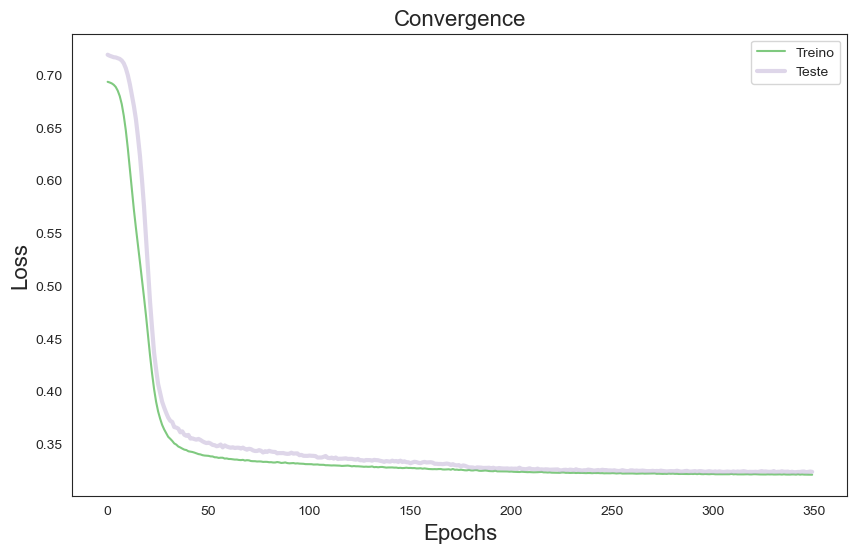

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Treino')
plt.plot(test_losses, label='Teste', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()

Vemos que a loss do nosso modelo diminui com o passar das épocas, como esperado, e converge próximo a época 350.

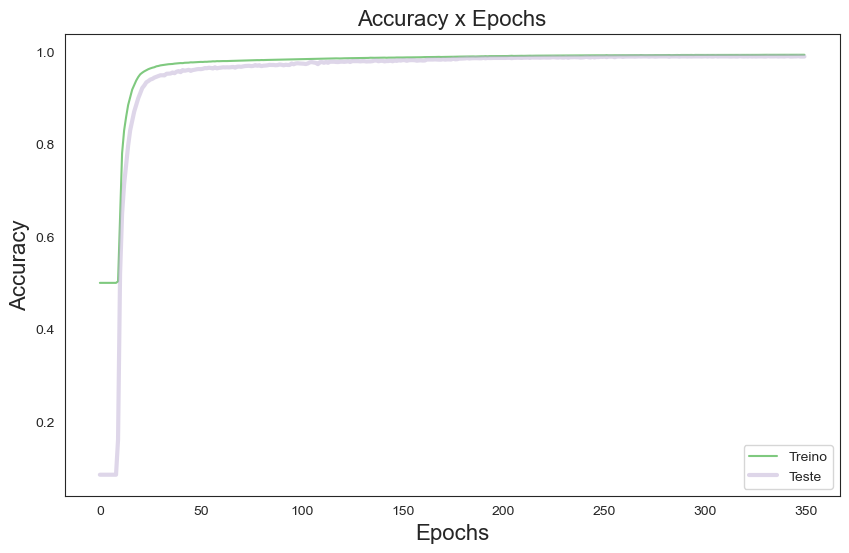

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Treino')
plt.plot(test_acc, label='Teste', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy x Epochs', fontsize=16)
plt.legend()
plt.show()

A acurácia do modelo aumenta com o passar das epócas até saturar em 0.99. Vemos também que a acurácia de teste e treino estão próximas indicando que não temos um problema de overfit. Por fim, vamos analisar o relatório e comparar o recall entre as duas classes pois é importante que o nosso modelo seja capaz de distinguir entre as transações fraudulentas e não fraudulentas.

In [34]:
# Chama a função e captura todos os retornos
_, _, true_labels, pred_labels = test(test_loader, model, epoch)

# Gera o classification report
print(classification_report(true_labels, pred_labels, target_names=['Sem fraude', 'Com fraude']))

Epoch: 349, Loss: 0.32375722378492355, Acc: 0.98925
              precision    recall  f1-score   support

  Sem fraude       1.00      0.99      0.99      3659
  Com fraude       0.90      0.98      0.94       341

    accuracy                           0.99      4000
   macro avg       0.95      0.98      0.97      4000
weighted avg       0.99      0.99      0.99      4000



Pelo relatório acima vemos que o modelo além da ótima acurácia (0.99) possui um bom recall para as duas classes. Este é um resultado importante pois no início vimos que nossos dados possuíam um grande desbalanceamento entre as classes.

## Conclusão

Neste projeto, desenvolvemos um modelo de deep learning utilizando o PyTorch para classificar transações de cartão de crédito entre fraudulentas e não fraudulentas. Após um breve tratamento e análise explorátoria de dados foram escolhidos construimos um perceptron multicamadas com além das camadas de entrada (com ReLU) e saída (com softmax) mais 5 camadas escondidas com ativações ReLU. O modelo obteve 99% de acurácia e 98% de recall após 350 épocas.